#### cfDNA存放目录：/home/maweicheng/database/cfDNA
#### 癌症CT存放目录：/home/maweicheng/database/khct/patch_output/split_libs
#### 正常结节存放目录：/home/maweicheng/resgsca/database/3slice/64/nocancer

In [14]:
import os
import glob
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import StratifiedShuffleSplit

random.seed(42)

modalities = ["Frag", "PFE", "NDR", "NDR2K"]
cf_base_dir = "/home/maweicheng/database/cfDNA"
ct_cancer_dir = "/home/maweicheng/database/Patch"
ct_normal_dir = "/home/maweicheng/database/LUNA/nocancer_patches_standardized"

save_train_path = "/home/maweicheng/database/cancer_normal/train.npz"
save_test_path = "/home/maweicheng/database/cancer_normal/test.npz"

# 统计跳过的样本
skipped_cancer = {"no_ct_files": [], "multiple_ct_files": [], "ct_load_error": [], "shape_error": [], "missing_modality": []}
skipped_normal = {"ct_load_error": [], "no_candidates": 0}

# 1. 读取所有模态数据
cf_data = {}
for mod in modalities:
    df_norm = pd.read_csv(os.path.join(cf_base_dir, "normal", f"healthy_{mod}.csv"), index_col=0)
    df_can  = pd.read_csv(os.path.join(cf_base_dir, "cancer",  f"cancer_{mod}.csv"), index_col=0)
    df_norm = df_norm.fillna(df_norm.mean())
    df_can  = df_can.fillna(df_can.mean())
    cf_data[mod] = {"normal": df_norm, "cancer": df_can}

# 获取共同的 index（癌症部分）
cancer_ids = cf_data["Frag"]["cancer"].index.tolist()
normal_ids = cf_data["Frag"]["normal"].index.tolist()

print(f"总癌症样本数: {len(cancer_ids)}")
print(f"总正常样本数: {len(normal_ids)}")

# 2. 处理 cancer 样本
X_cancer = {mod: [] for mod in modalities}
CT_cancer = []
y_cancer = []
id_cancer = []

for cid in cancer_ids:
    ct_pattern = os.path.join(ct_cancer_dir, cid, "*.npz")
    ct_files = glob.glob(ct_pattern)

    # 确保该病人目录下确实有一个 .npz 文件
    if len(ct_files) == 0:
        skipped_cancer["no_ct_files"].append(cid)
        print(f"[跳过-癌症] {cid}: 未找到CT文件")
        continue
    elif len(ct_files) > 1:
        skipped_cancer["multiple_ct_files"].append(cid)
        print(f"[跳过-癌症] {cid}: 找到多个CT文件 ({len(ct_files)}个)")
        continue

    ct_path = ct_files[0]
    try:
        ct_npz = np.load(ct_path)
        ct_data = ct_npz["data"]
        # 癌症数据需要转置通道：(3,64,64) -> (64,64,3)
        if ct_data.shape == (3, 64, 64):
            ct_data = np.transpose(ct_data, (1, 2, 0)) 

        if ct_data.shape != (64, 64, 3):
            skipped_cancer["shape_error"].append(cid)
            print(f"[跳过-癌症] {cid}: CT形状异常 {ct_data.shape} (应为 (64, 64, 3))")
            continue  

    except Exception as e:
        skipped_cancer["ct_load_error"].append(cid)
        print(f"[跳过-癌症] {cid}: CT加载失败 - {e}")
        continue

    # 检查 cfDNA 模态是否齐全
    missing_modalities = [mod for mod in modalities if cid not in cf_data[mod]["cancer"].index]
    if missing_modalities:
        skipped_cancer["missing_modality"].append(cid)
        print(f"[跳过-癌症] {cid}: 缺失模态数据 {missing_modalities}")
        continue

    # 添加数据
    for mod in modalities:
        X_cancer[mod].append(cf_data[mod]["cancer"].loc[cid].values.astype(np.float32))
    CT_cancer.append(ct_data.astype(np.float32))
    y_cancer.append(1)
    id_cancer.append(cid)

print(f"成功处理癌症样本: {len(y_cancer)}/{len(cancer_ids)}")

# 3. 处理 normal 样本
X_normal = {mod: [] for mod in modalities}
CT_normal = []
y_normal = []
id_normal = []

used_nocancer = set()
available_ct_files = sorted(os.listdir(ct_normal_dir))

for nid in normal_ids:
    # 随机选择未使用的 CT 文件
    candidates = list(set(available_ct_files) - used_nocancer)
    if not candidates:
        skipped_normal["no_candidates"] = len(normal_ids) - len(y_normal)
        print(f"[跳过-正常] 剩余 {len(normal_ids) - len(y_normal)} 个样本: CT文件不够用")
        break  # 不够用了
    
    selected = random.choice(candidates)
    used_nocancer.add(selected)
    ct_path = os.path.join(ct_normal_dir, selected)
    try:
        ct_npz = np.load(ct_path)
        ct_data = ct_npz["data"]
        # 正常样本已经是标准化格式，不需要转置通道
        # 直接使用 (3,64,64) 格式，然后转换为 (64,64,3)
        if ct_data.shape == (3, 64, 64):
            ct_data = np.transpose(ct_data, (1, 2, 0))
        
        if ct_data.shape != (64, 64, 3):
            print(f"[跳过-正常] {nid}: CT形状异常 {ct_data.shape} (应为 (64, 64, 3))")
            continue
            
    except Exception as e:
        skipped_normal["ct_load_error"].append(nid)
        print(f"[跳过-正常] {nid}: CT加载失败 (文件: {selected}) - {e}")
        continue

    for mod in modalities:
        X_normal[mod].append(cf_data[mod]["normal"].loc[nid].values.astype(np.float32))
    CT_normal.append(ct_data.astype(np.float32))
    y_normal.append(0)
    id_normal.append(nid)

print(f"成功处理正常样本: {len(y_normal)}/{len(normal_ids)}")

# 4. 组装训练与测试集（90% 训练 + 10% 测试，按顺序切分）
def split_data(X_dict, CT_list, y_list, id_list, test_size=0.1, random_state=42):
    # 确保所有模态数据和CT数据的样本数一致
    assert all(len(X_dict[mod]) == len(y_list) for mod in modalities)
    assert len(CT_list) == len(y_list)
    assert len(id_list) == len(y_list)
    
    # 使用分层抽样划分
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    
    # y_list需要是numpy数组
    y_array = np.array(y_list)
    
    # 获取划分索引
    for train_idx, test_idx in sss.split(np.zeros(len(y_array)), y_array):
        pass  # 只需要第一次划分
        
    # 划分数据
    train = {mod: np.stack([X_dict[mod][i] for i in train_idx]) for mod in modalities}
    test = {mod: np.stack([X_dict[mod][i] for i in test_idx]) for mod in modalities}
    
    train["CT"] = np.stack([CT_list[i] for i in train_idx])
    test["CT"] = np.stack([CT_list[i] for i in test_idx])
    train["y"] = y_array[train_idx]
    test["y"] = y_array[test_idx]
    train["id"] = np.array([id_list[i] for i in train_idx])
    test["id"] = np.array([id_list[i] for i in test_idx])
    return train, test

# 使用示例
print(f"\n=== 数据统计 ===")
print(f"癌症样本数: {len(y_cancer)}")
print(f"正常样本数: {len(y_normal)}")

# 打印跳过统计
print(f"\n=== 跳过样本统计 ===")
print("癌症样本跳过原因:")
for reason, samples in skipped_cancer.items():
    if isinstance(samples, list) and len(samples) > 0:
        print(f"  {reason}: {len(samples)}个 - {samples[:5]}{'...' if len(samples) > 5 else ''}")
    
print("正常样本跳过原因:")
for reason, count in skipped_normal.items():
    if isinstance(count, int) and count > 0:
        print(f"  {reason}: {count}个")
    elif isinstance(count, list) and len(count) > 0:
        print(f"  {reason}: {len(count)}个 - {count[:5]}{'...' if len(count) > 5 else ''}")

# 设置相同的random_state以确保可重复性
train_can, test_can = split_data(X_cancer, CT_cancer, y_cancer, id_cancer, test_size=0.1, random_state=42)
train_nor, test_nor = split_data(X_normal, CT_normal, y_normal, id_normal, test_size=0.1, random_state=42)

# 合并
train_all = {key: np.concatenate([train_can[key], train_nor[key]]) for key in train_can}
test_all  = {key: np.concatenate([test_can[key], test_nor[key]])   for key in test_can}

# 5. 保存
np.savez_compressed(save_train_path, **train_all)
np.savez_compressed(save_test_path,  **test_all)
print(f"\n已保存：{save_train_path}")
print(f"已保存：{save_test_path}")
print(f"\n最终训练集样本数: {len(train_all['y'])}")
print(f"最终测试集样本数: {len(test_all['y'])}")

总癌症样本数: 397
总正常样本数: 340
[跳过-癌症] Lib-002: 未找到CT文件
[跳过-癌症] Lib-003: 未找到CT文件
[跳过-癌症] Lib-002: 未找到CT文件
[跳过-癌症] Lib-003: 未找到CT文件
[跳过-癌症] Lib-030: 未找到CT文件
[跳过-癌症] Lib-031: 未找到CT文件
[跳过-癌症] Lib-030: 未找到CT文件
[跳过-癌症] Lib-031: 未找到CT文件
[跳过-癌症] Lib-037: 未找到CT文件
[跳过-癌症] Lib-038: 未找到CT文件
[跳过-癌症] Lib-037: 未找到CT文件
[跳过-癌症] Lib-038: 未找到CT文件
[跳过-癌症] Lib-047: 未找到CT文件
[跳过-癌症] Lib-048: 未找到CT文件
[跳过-癌症] Lib-049: 未找到CT文件
[跳过-癌症] Lib-050: 未找到CT文件
[跳过-癌症] Lib-062: 未找到CT文件
[跳过-癌症] Lib-063: 未找到CT文件
[跳过-癌症] Lib-047: 未找到CT文件
[跳过-癌症] Lib-048: 未找到CT文件
[跳过-癌症] Lib-049: 未找到CT文件
[跳过-癌症] Lib-050: 未找到CT文件
[跳过-癌症] Lib-062: 未找到CT文件
[跳过-癌症] Lib-063: 未找到CT文件
[跳过-癌症] Lib-072: 未找到CT文件
[跳过-癌症] Lib-073: 未找到CT文件
[跳过-癌症] Lib-072: 未找到CT文件
[跳过-癌症] Lib-073: 未找到CT文件
[跳过-癌症] Lib-124: 未找到CT文件
[跳过-癌症] Lib-124: 未找到CT文件
[跳过-癌症] Lib-129: 未找到CT文件
[跳过-癌症] Lib-129: 未找到CT文件
[跳过-癌症] Lib-137: 未找到CT文件
[跳过-癌症] Lib-137: 未找到CT文件
[跳过-癌症] Lib-141: 未找到CT文件
[跳过-癌症] Lib-141: 未找到CT文件
[跳过-癌症] Lib-177: 未找到CT文件
[跳过-癌症] Lib-179: 未找到CT文件
[跳过-癌症] Lib-180: 未找到CT文件
[

# 这儿是恶性良性的

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import StratifiedShuffleSplit
modalities = ["Frag", "PFE", "NDR", "NDR2K"]
cf_base_dir = "/home/maweicheng/database/cfDNA"
ct_cancer_dir = "/home/maweicheng/database/Patch"

save_train_path = "/home/maweicheng/database/cancer_benign/train.npz"
save_test_path = "/home/maweicheng/database/cancer_benign/test.npz"

# 统计跳过的样本
skipped_cancer = {"no_ct_files": [], "multiple_ct_files": [], "ct_load_error": [], "shape_error": [], "missing_modality": []}
skipped_benign = {"no_ct_files": [], "multiple_ct_files": [], "ct_load_error": [], "shape_error": [], "missing_modality": []}

# 1. 读取所有模态数据 - 修正：良性和恶性都从癌症文件中读取，通过ID区分
cf_data = {}
for mod in modalities:
    df_cancer = pd.read_csv(os.path.join(cf_base_dir, "cancer", f"cancer_{mod}.csv"), index_col=0)
    df_cancer = df_cancer.fillna(df_cancer.mean())
    cf_data[mod] = df_cancer  # 统一使用癌症数据文件，通过ID列表区分良性恶性

# Library ID 列表
cancer_ids = ["Lib-004", "Lib-019", "Lib-020", "Lib-021", "Lib-022", "Lib-025", "Lib-028", "Lib-032", "Lib-039", "Lib-040", "Lib-066","Lib-067", "Lib-068", 
              "Lib-069", "Lib-076", "Lib-077", "Lib-082", "Lib-083", "Lib-086", "Lib-087", "Lib-088", "Lib-090", "Lib-093", "Lib-094","Lib-107", "Lib-108",
              "Lib-109", "Lib-110", "Lib-121", "Lib-122", "Lib-123", "Lib-124", "Lib-126", "Lib-128", "Lib-130", "Lib-131", "Lib-137","Lib-140", "Lib-142", 
              "Lib-143", "Lib-145", "Lib-149", "Lib-150", "Lib-157", "Lib-158", "Lib-159", "Lib-160", "Lib-206", "Lib-220", "Lib-177", "Lib-181", "Lib-183", 
              "Lib-184", "Lib-187", "Lib-188", "Lib-191", "Lib-192", "Lib-194", "Lib-196", "Lib-197", "Lib-201", "Lib-201", "Lib-203", "Lib-209", "Lib-210", 
              "Lib-211", "Lib-212", "Lib-217", "Lib-221", "Lib-222", "Lib-224", "Lib-225", "Lib-226", "Lib-227", "Lib-228", "Lib-230", "Lib-232", "Lib-234",
              "Lib-235", "Lib-236", "Lib-237", "Lib-238", "Lib-239", "Lib-240", "Lib-242", "Lib-245", "Lib-257", "Lib-258", "Lib-260", "Lib-263", "Lib-264", 
              "Lib-265", "Lib-267", "Lib-268", "Lib-269", "Lib-270", "Lib-271", "Lib-272", "Lib-273", "Lib-274", "Lib-275", "Lib-276", "Lib-277", "Lib-278",
              "Lib-279", "Lib-280", "Lib-281", "Lib-282", "Lib-283", "Lib-284", "Lib-286", "Lib-294", "Lib-296", "Lib-297", "Lib-299", "Lib-300", "Lib-301", 
              "Lib-305", "Lib-307", "Lib-308", "Lib-311", "Lib-313", "Lib-314", "Lib-315", "Lib-316", "Lib-318", "Lib-319", "Lib-321", "Lib-323", "Lib-324", 
              "Lib-325", "Lib-326", "Lib-327", "Lib-328", "Lib-329", "Lib-330", "Lib-332", "Lib-333", "Lib-334", "Lib-335", "Lib-337", "Lib-338", "Lib-339",
              "Lib-342", "Lib-343", "Lib-346", "Lib-347", "Lib-355", "Lib-356", "Lib-358", "Lib-359", "Lib-360", "Lib-361", "Lib-362", "Lib-363", "Lib-367", 
              "Lib-368", "Lib-369", "Lib-370", "Lib-371", "Lib-372", "Lib-373", "Lib-374", "Lib-375", "Lib-376", "Lib-377", "Lib-378", "Lib-379", "Lib-380", 
              "Lib-381", "Lib-383", "Lib-384", "Lib-385", "Lib-387", "Lib-391", "Lib-392", "Lib-393", "Lib-394", "Lib-396", "Lib-399", "Lib-400", "Lib-402", 
              "Lib-404", "Lib-405", "Lib-407", "Lib-408", "Lib-409", "Lib-410", "Lib-412", "Lib-413", "Lib-414", "Lib-415", "Lib-417", "Lib-418", "Lib-419", 
              "Lib-420", "Lib-421", "Lib-425", "Lib-426", "Lib-427", "Lib-428", "Lib-430", "Lib-431", "Lib-433", "Lib-434", "Lib-435", "Lib-436", "Lib-437", 
              "Lib-439", "Lib-440", "Lib-441", "Lib-443", "Lib-444", "Lib-445", "Lib-446", "Lib-447", "Lib-448", "Lib-450", "Lib-451", "Lib-452", "Lib-453", 
              "Lib-454", "Lib-455", "Lib-457", "Lib-458", "Lib-459", "Lib-460", "Lib-463", "Lib-465", "Lib-466", "Lib-468", "Lib-470", "Lib-472", "Lib-473", 
              "Lib-476", "Lib-477", "Lib-479", "Lib-480", "Lib-481", "Lib-484", "Lib-486", "Lib-488", "Lib-521", "Lib-523", "Lib-525", "Lib-526", "Lib-527", 
              "Lib-528", "Lib-529", "Lib-532", "Lib-533", "Lib-534", "Lib-535", "Lib-537", "Lib-539", "Lib-540", "Lib-541", "Lib-544", "Lib-545", "Lib-546", 
              "Lib-548", "Lib-549"]

benign_ids = ["Lib-005", "Lib-006", "Lib-026", "Lib-027", "Lib-030", "Lib-031", "Lib-033", "Lib-034", "Lib-035", "Lib-036", "Lib-064", "Lib-065", "Lib-070",
              "Lib-071", "Lib-074", "Lib-075", "Lib-084", "Lib-085", "Lib-089", "Lib-091", "Lib-092", "Lib-095", "Lib-096", "Lib-097", "Lib-125", "Lib-132",
              "Lib-138", "Lib-144", "Lib-147", "Lib-148", "Lib-151", "Lib-152", "Lib-153", "Lib-154","Lib-179", "Lib-180", "Lib-182", "Lib-185", "Lib-186", 
              "Lib-189", "Lib-190", "Lib-193", "Lib-195", "Lib-204", "Lib-208", "Lib-223", "Lib-229", "Lib-231", "Lib-233", "Lib-241", "Lib-243", "Lib-244", 
              "Lib-256", "Lib-259", "Lib-262", "Lib-266", "Lib-293", "Lib-295", "Lib-298", "Lib-302", "Lib-304", "Lib-306", "Lib-310", "Lib-312", "Lib-317", 
              "Lib-320", "Lib-322", "Lib-331", "Lib-336", "Lib-340", "Lib-344", "Lib-345", "Lib-357", "Lib-364", "Lib-365", "Lib-382", "Lib-386", "Lib-389", 
              "Lib-390", "Lib-397", "Lib-401", "Lib-403", "Lib-406", "Lib-411", "Lib-422", "Lib-432", "Lib-438", "Lib-442", "Lib-456", "Lib-471", "Lib-475", 
              "Lib-478", "Lib-485", "Lib-489", "Lib-522", "Lib-524", "Lib-530", "Lib-531", "Lib-538", "Lib-542", "Lib-550", "Lib-551", "Lib-464"]

print(f"总恶性样本数: {len(cancer_ids)}")
print(f"总良性样本数: {len(benign_ids)}")

# 2. 处理 cancer (恶性) 样本
X_cancer = {mod: [] for mod in modalities}
CT_cancer = []
y_cancer = []
id_cancer = []

for cid in cancer_ids:
    ct_pattern = os.path.join(ct_cancer_dir, cid, "*.npz")
    ct_files = glob.glob(ct_pattern)

    # 确保该病人目录下确实有一个 .npz 文件
    if len(ct_files) == 0:
        skipped_cancer["no_ct_files"].append(cid)
        print(f"[跳过-恶性] {cid}: 未找到CT文件")
        continue
    elif len(ct_files) > 1:
        skipped_cancer["multiple_ct_files"].append(cid)
        print(f"[跳过-恶性] {cid}: 找到多个CT文件 ({len(ct_files)}个)")
        continue

    ct_path = ct_files[0]
    try:
        ct_npz = np.load(ct_path)
        ct_data = ct_npz["data"]
        if ct_data.shape == (3, 64, 64):
            ct_data = np.transpose(ct_data, (1, 2, 0)) 

        if ct_data.shape != (64, 64, 3):
            skipped_cancer["shape_error"].append(cid)
            print(f"[跳过-恶性] {cid}: CT形状异常 {ct_data.shape} (应为 (64, 64, 3))")
            continue  

    except Exception as e:
        skipped_cancer["ct_load_error"].append(cid)
        print(f"[跳过-恶性] {cid}: CT加载失败 - {e}")
        continue

    # 检查 cfDNA 模态是否齐全
    missing_modalities = [mod for mod in modalities if cid not in cf_data[mod].index]
    if missing_modalities:
        skipped_cancer["missing_modality"].append(cid)
        print(f"[跳过-恶性] {cid}: 缺失模态数据 {missing_modalities}")
        continue

    # 添加数据
    for mod in modalities:
        X_cancer[mod].append(cf_data[mod].loc[cid].values.astype(np.float32))
    CT_cancer.append(ct_data.astype(np.float32))
    y_cancer.append(1)  # 恶性标记为1
    id_cancer.append(cid)

print(f"成功处理恶性样本: {len(y_cancer)}/{len(cancer_ids)}")

# 3. 处理 benign (良性) 样本
X_benign = {mod: [] for mod in modalities}
CT_benign = []
y_benign = []
id_benign = []

for bid in benign_ids:
    ct_pattern = os.path.join(ct_cancer_dir, bid, "*.npz")
    ct_files = glob.glob(ct_pattern)

    # 确保该病人目录下确实有一个 .npz 文件
    if len(ct_files) == 0:
        skipped_benign["no_ct_files"].append(bid)
        print(f"[跳过-良性] {bid}: 未找到CT文件")
        continue
    elif len(ct_files) > 1:
        skipped_benign["multiple_ct_files"].append(bid)
        print(f"[跳过-良性] {bid}: 找到多个CT文件 ({len(ct_files)}个)")
        continue

    ct_path = ct_files[0]
    try:
        ct_npz = np.load(ct_path)
        ct_data = ct_npz["data"]
        if ct_data.shape == (3, 64, 64):
            ct_data = np.transpose(ct_data, (1, 2, 0)) 

        if ct_data.shape != (64, 64, 3):
            skipped_benign["shape_error"].append(bid)
            print(f"[跳过-良性] {bid}: CT形状异常 {ct_data.shape} (应为 (64, 64, 3))")
            continue  

    except Exception as e:
        skipped_benign["ct_load_error"].append(bid)
        print(f"[跳过-良性] {bid}: CT加载失败 - {e}")
        continue

    # 检查 cfDNA 模态是否齐全
    missing_modalities = [mod for mod in modalities if bid not in cf_data[mod].index]
    if missing_modalities:
        skipped_benign["missing_modality"].append(bid)
        print(f"[跳过-良性] {bid}: 缺失模态数据 {missing_modalities}")
        continue

    # 添加数据
    for mod in modalities:
        X_benign[mod].append(cf_data[mod].loc[bid].values.astype(np.float32))
    CT_benign.append(ct_data.astype(np.float32))
    y_benign.append(0)  # 良性标记为0
    id_benign.append(bid)

print(f"成功处理良性样本: {len(y_benign)}/{len(benign_ids)}")

# 4. 组装训练与测试集
def split_data(X_dict, CT_list, y_list, id_list, test_size=0.3, random_state=42):
    # 确保所有模态数据和CT数据的样本数一致
    assert all(len(X_dict[mod]) == len(y_list) for mod in modalities)
    assert len(CT_list) == len(y_list)
    assert len(id_list) == len(y_list)
    
    # 使用分层抽样划分
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    
    # y_list需要是numpy数组
    y_array = np.array(y_list)
    
    # 获取划分索引
    for train_idx, test_idx in sss.split(np.zeros(len(y_array)), y_array):
        pass  # 只需要第一次划分
        
    # 划分数据
    train = {mod: np.stack([X_dict[mod][i] for i in train_idx]) for mod in modalities}
    test = {mod: np.stack([X_dict[mod][i] for i in test_idx]) for mod in modalities}
    
    train["CT"] = np.stack([CT_list[i] for i in train_idx])
    test["CT"] = np.stack([CT_list[i] for i in test_idx])
    train["y"] = y_array[train_idx]
    test["y"] = y_array[test_idx]
    train["id"] = np.array([id_list[i] for i in train_idx])
    test["id"] = np.array([id_list[i] for i in test_idx])
    return train, test

# 统计信息
print(f"\n=== 数据统计 ===")
print(f"恶性样本数: {len(y_cancer)}")
print(f"良性样本数: {len(y_benign)}")

# 打印跳过统计
print(f"\n=== 跳过样本统计 ===")
print("恶性样本跳过原因:")
for reason, samples in skipped_cancer.items():
    if isinstance(samples, list) and len(samples) > 0:
        print(f"  {reason}: {len(samples)}个 - {samples[:5]}{'...' if len(samples) > 5 else ''}")
    
print("良性样本跳过原因:")
for reason, samples in skipped_benign.items():
    if isinstance(samples, list) and len(samples) > 0:
        print(f"  {reason}: {len(samples)}个 - {samples[:5]}{'...' if len(samples) > 5 else ''}")

# 设置相同的random_state以确保可重复性
train_cancer, test_cancer = split_data(X_cancer, CT_cancer, y_cancer, id_cancer, test_size=0.1, random_state=42)
train_benign, test_benign = split_data(X_benign, CT_benign, y_benign, id_benign, test_size=0.1, random_state=42)

# 合并
train_all = {key: np.concatenate([train_cancer[key], train_benign[key]]) for key in train_cancer}
test_all  = {key: np.concatenate([test_cancer[key], test_benign[key]])   for key in test_cancer}

# 5. 保存
np.savez_compressed(save_train_path, **train_all)
np.savez_compressed(save_test_path,  **test_all)
print(f"\n已保存：{save_train_path}")
print(f"已保存：{save_test_path}")
print(f"\n最终训练集样本数: {len(train_all['y'])}")
print(f"最终测试集样本数: {len(test_all['y'])}")
print(f"训练集中恶性样本: {np.sum(train_all['y'])}, 良性样本: {len(train_all['y']) - np.sum(train_all['y'])}")
print(f"测试集中恶性样本: {np.sum(test_all['y'])}, 良性样本: {len(test_all['y']) - np.sum(test_all['y'])}")

总恶性样本数: 262
总良性样本数: 103
[跳过-恶性] Lib-124: 未找到CT文件
[跳过-恶性] Lib-124: 未找到CT文件
[跳过-恶性] Lib-137: 未找到CT文件
[跳过-恶性] Lib-137: 未找到CT文件
[跳过-恶性] Lib-206: 未找到CT文件
[跳过-恶性] Lib-177: 未找到CT文件
[跳过-恶性] Lib-181: 未找到CT文件
[跳过-恶性] Lib-184: 缺失模态数据 ['Frag', 'PFE', 'NDR', 'NDR2K']
[跳过-恶性] Lib-187: 未找到CT文件
[跳过-恶性] Lib-206: 未找到CT文件
[跳过-恶性] Lib-177: 未找到CT文件
[跳过-恶性] Lib-181: 未找到CT文件
[跳过-恶性] Lib-184: 缺失模态数据 ['Frag', 'PFE', 'NDR', 'NDR2K']
[跳过-恶性] Lib-187: 未找到CT文件
[跳过-恶性] Lib-191: 未找到CT文件
[跳过-恶性] Lib-192: 未找到CT文件
[跳过-恶性] Lib-196: 未找到CT文件
[跳过-恶性] Lib-197: 未找到CT文件
[跳过-恶性] Lib-201: 未找到CT文件
[跳过-恶性] Lib-201: 未找到CT文件
[跳过-恶性] Lib-191: 未找到CT文件
[跳过-恶性] Lib-192: 未找到CT文件
[跳过-恶性] Lib-196: 未找到CT文件
[跳过-恶性] Lib-197: 未找到CT文件
[跳过-恶性] Lib-201: 未找到CT文件
[跳过-恶性] Lib-201: 未找到CT文件
[跳过-恶性] Lib-210: 未找到CT文件
[跳过-恶性] Lib-210: 未找到CT文件
[跳过-恶性] Lib-222: 未找到CT文件
[跳过-恶性] Lib-222: 未找到CT文件
[跳过-恶性] Lib-236: 未找到CT文件
[跳过-恶性] Lib-236: 未找到CT文件
[跳过-恶性] Lib-263: 未找到CT文件
[跳过-恶性] Lib-263: 未找到CT文件
[跳过-恶性] Lib-278: 缺失模态数据 ['Frag', 'PFE', 'NDR', 'NDR2K']
[跳过-恶性] 

# 下面是分亚型

In [2]:
# 懒得改变量名字了，Cancer是LUAD，Benign是LUSC
import os
import glob
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import StratifiedShuffleSplit
modalities = ["Frag", "PFE", "NDR", "NDR2K"]
cf_base_dir = "/home/maweicheng/database/cfDNA"
ct_cancer_dir = "/home/maweicheng/database/Patch"

save_train_path = "/home/maweicheng/database/cancer_subtype/train.npz"
save_test_path = "/home/maweicheng/database/cancer_subtype/test.npz"

# 统计跳过的样本
skipped_cancer = {"no_ct_files": [], "multiple_ct_files": [], "ct_load_error": [], "shape_error": [], "missing_modality": []}
skipped_benign = {"no_ct_files": [], "multiple_ct_files": [], "ct_load_error": [], "shape_error": [], "missing_modality": []}

# 1. 读取所有模态数据 - 修正：良性和恶性都从癌症文件中读取，通过ID区分
cf_data = {}
for mod in modalities:
    df_cancer = pd.read_csv(os.path.join(cf_base_dir, "cancer", f"cancer_{mod}.csv"), index_col=0)
    df_cancer = df_cancer.fillna(df_cancer.mean())
    cf_data[mod] = df_cancer  # 统一使用癌症数据文件，通过ID列表区分良性恶性

# Library ID 列表
cancer_ids = ["Lib-206", "Lib-220", "Lib-177", "Lib-181", "Lib-183", "Lib-184", "Lib-187", "Lib-191", "Lib-192", "Lib-194", "Lib-196", "Lib-197", "Lib-203", "Lib-209", "Lib-210", "Lib-211", "Lib-212", "Lib-217", "Lib-221", "Lib-222", "Lib-224", "Lib-226", "Lib-227", "Lib-228", "Lib-232", "Lib-234", "Lib-236", "Lib-237", "Lib-238", "Lib-239", "Lib-240", "Lib-245", "Lib-257", "Lib-258", "Lib-260", "Lib-263", "Lib-264", "Lib-267", "Lib-268", "Lib-269", "Lib-270", "Lib-271", "Lib-272", "Lib-273", "Lib-274", "Lib-275", "Lib-276", "Lib-277", "Lib-278", "Lib-279", "Lib-280", "Lib-281", "Lib-282", "Lib-283", "Lib-284", "Lib-286", "Lib-294", "Lib-296", "Lib-297", "Lib-299", "Lib-300", "Lib-301", "Lib-305", "Lib-307", "Lib-311", "Lib-313", "Lib-314", "Lib-315", "Lib-318", "Lib-319", "Lib-321", "Lib-323", "Lib-324", "Lib-325", "Lib-326", "Lib-327", "Lib-328", "Lib-329", "Lib-330", "Lib-332", "Lib-334", "Lib-335", "Lib-339", "Lib-342", "Lib-343", "Lib-346", "Lib-347", "Lib-355", "Lib-356", "Lib-358", "Lib-360", "Lib-361", "Lib-362", "Lib-363", "Lib-367", "Lib-369", "Lib-370", "Lib-371", "Lib-372", "Lib-373", "Lib-374", "Lib-375", "Lib-377", "Lib-378", "Lib-379", "Lib-380", "Lib-381", "Lib-383", "Lib-385", "Lib-387", "Lib-393", "Lib-394", "Lib-396", "Lib-402", "Lib-404", "Lib-405", "Lib-408", "Lib-409", "Lib-410", "Lib-412", "Lib-413", "Lib-414", "Lib-415", "Lib-417", "Lib-418", "Lib-419", "Lib-420", "Lib-421", "Lib-425", "Lib-426", "Lib-427", "Lib-428", "Lib-430", "Lib-433", "Lib-434", "Lib-435", "Lib-436", "Lib-437", "Lib-439", "Lib-440", "Lib-441", "Lib-443", "Lib-444", "Lib-445", "Lib-446", "Lib-450", "Lib-451", "Lib-452", "Lib-453", "Lib-454", "Lib-455", "Lib-457", "Lib-458", "Lib-459", "Lib-463", "Lib-465", "Lib-468", "Lib-470", "Lib-472", "Lib-473", "Lib-476", "Lib-477", "Lib-479", "Lib-480", "Lib-481", "Lib-484", "Lib-486", "Lib-521", "Lib-523", "Lib-525", "Lib-527", "Lib-529", "Lib-532", "Lib-533", "Lib-535", "Lib-537", "Lib-540", "Lib-544", "Lib-545", "Lib-546", "Lib-548"]

benign_ids = ["Lib-201", "Lib-201", "Lib-225", "Lib-230", "Lib-235", "Lib-242", "Lib-308", "Lib-316", "Lib-333", "Lib-338", "Lib-359", "Lib-368", "Lib-384", "Lib-391", "Lib-392", "Lib-399", "Lib-400", "Lib-407", "Lib-431", "Lib-447", "Lib-448", "Lib-460", "Lib-466", "Lib-526", "Lib-528", "Lib-534", "Lib-539", "Lib-541"]

print(f"LUAD样本数: {len(cancer_ids)}")
print(f"LUSC样本数: {len(benign_ids)}")

# 2. 处理 cancer (LUAD) 样本
X_cancer = {mod: [] for mod in modalities}
CT_cancer = []
y_cancer = []
id_cancer = []

for cid in cancer_ids:
    ct_pattern = os.path.join(ct_cancer_dir, cid, "*.npz")
    ct_files = glob.glob(ct_pattern)

    # 确保该病人目录下确实有一个 .npz 文件
    if len(ct_files) == 0:
        skipped_cancer["no_ct_files"].append(cid)
        print(f"[跳过-LUAD] {cid}: 未找到CT文件")
        continue
    elif len(ct_files) > 1:
        skipped_cancer["multiple_ct_files"].append(cid)
        print(f"[跳过-LUAD] {cid}: 找到多个CT文件 ({len(ct_files)}个)")
        continue

    ct_path = ct_files[0]
    try:
        ct_npz = np.load(ct_path)
        ct_data = ct_npz["data"]
        if ct_data.shape == (3, 64, 64):
            ct_data = np.transpose(ct_data, (1, 2, 0)) 

        if ct_data.shape != (64, 64, 3):
            skipped_cancer["shape_error"].append(cid)
            print(f"[跳过-LUAD] {cid}: CT形状异常 {ct_data.shape} (应为 (64, 64, 3))")
            continue  

    except Exception as e:
        skipped_cancer["ct_load_error"].append(cid)
        print(f"[跳过-LUAD] {cid}: CT加载失败 - {e}")
        continue

    # 检查 cfDNA 模态是否齐全
    missing_modalities = [mod for mod in modalities if cid not in cf_data[mod].index]
    if missing_modalities:
        skipped_cancer["missing_modality"].append(cid)
        print(f"[跳过-LUAD] {cid}: 缺失模态数据 {missing_modalities}")
        continue

    # 添加数据
    for mod in modalities:
        X_cancer[mod].append(cf_data[mod].loc[cid].values.astype(np.float32))
    CT_cancer.append(ct_data.astype(np.float32))
    y_cancer.append(1)  # 恶性标记为1
    id_cancer.append(cid)

print(f"成功处理LUAD样本: {len(y_cancer)}/{len(cancer_ids)}")

# 3. 处理 benign (LUSC) 样本
X_benign = {mod: [] for mod in modalities}
CT_benign = []
y_benign = []
id_benign = []

for bid in benign_ids:
    ct_pattern = os.path.join(ct_cancer_dir, bid, "*.npz")
    ct_files = glob.glob(ct_pattern)

    # 确保该病人目录下确实有一个 .npz 文件
    if len(ct_files) == 0:
        skipped_benign["no_ct_files"].append(bid)
        print(f"[跳过-LUSC] {bid}: 未找到CT文件")
        continue
    elif len(ct_files) > 1:
        skipped_benign["multiple_ct_files"].append(bid)
        print(f"[跳过-LUSC] {bid}: 找到多个CT文件 ({len(ct_files)}个)")
        continue

    ct_path = ct_files[0]
    try:
        ct_npz = np.load(ct_path)
        ct_data = ct_npz["data"]
        if ct_data.shape == (3, 64, 64):
            ct_data = np.transpose(ct_data, (1, 2, 0)) 

        if ct_data.shape != (64, 64, 3):
            skipped_benign["shape_error"].append(bid)
            print(f"[跳过-LUSC] {bid}: CT形状异常 {ct_data.shape} (应为 (64, 64, 3))")
            continue  

    except Exception as e:
        skipped_benign["ct_load_error"].append(bid)
        print(f"[跳过-LUSC] {bid}: CT加载失败 - {e}")
        continue

    # 检查 cfDNA 模态是否齐全
    missing_modalities = [mod for mod in modalities if bid not in cf_data[mod].index]
    if missing_modalities:
        skipped_benign["missing_modality"].append(bid)
        print(f"[跳过-LUSC] {bid}: 缺失模态数据 {missing_modalities}")
        continue

    # 添加数据
    for mod in modalities:
        X_benign[mod].append(cf_data[mod].loc[bid].values.astype(np.float32))
    CT_benign.append(ct_data.astype(np.float32))
    y_benign.append(0)  # 良性标记为0
    id_benign.append(bid)

print(f"成功处理LUSC样本: {len(y_benign)}/{len(benign_ids)}")

# 4. 组装训练与测试集
def split_data(X_dict, CT_list, y_list, id_list, test_size=0.3, random_state=42):
    # 确保所有模态数据和CT数据的样本数一致
    assert all(len(X_dict[mod]) == len(y_list) for mod in modalities)
    assert len(CT_list) == len(y_list)
    assert len(id_list) == len(y_list)
    
    # 使用分层抽样划分
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    
    # y_list需要是numpy数组
    y_array = np.array(y_list)
    
    # 获取划分索引
    for train_idx, test_idx in sss.split(np.zeros(len(y_array)), y_array):
        pass  # 只需要第一次划分
        
    # 划分数据
    train = {mod: np.stack([X_dict[mod][i] for i in train_idx]) for mod in modalities}
    test = {mod: np.stack([X_dict[mod][i] for i in test_idx]) for mod in modalities}
    
    train["CT"] = np.stack([CT_list[i] for i in train_idx])
    test["CT"] = np.stack([CT_list[i] for i in test_idx])
    train["y"] = y_array[train_idx]
    test["y"] = y_array[test_idx]
    train["id"] = np.array([id_list[i] for i in train_idx])
    test["id"] = np.array([id_list[i] for i in test_idx])
    return train, test

# 统计信息
print(f"\n=== 数据统计 ===")
print(f"LUAD样本数: {len(y_cancer)}")
print(f"LUSC样本数: {len(y_benign)}")

# 打印跳过统计
print(f"\n=== 跳过样本统计 ===")
print("LUAD样本跳过原因:")
for reason, samples in skipped_cancer.items():
    if isinstance(samples, list) and len(samples) > 0:
        print(f"  {reason}: {len(samples)}个 - {samples[:5]}{'...' if len(samples) > 5 else ''}")
    
print("LUSC样本跳过原因:")
for reason, samples in skipped_benign.items():
    if isinstance(samples, list) and len(samples) > 0:
        print(f"  {reason}: {len(samples)}个 - {samples[:5]}{'...' if len(samples) > 5 else ''}")

# 设置相同的random_state以确保可重复性
train_cancer, test_cancer = split_data(X_cancer, CT_cancer, y_cancer, id_cancer, test_size=0.1, random_state=42)
train_benign, test_benign = split_data(X_benign, CT_benign, y_benign, id_benign, test_size=0.1, random_state=42)

# 合并
train_all = {key: np.concatenate([train_cancer[key], train_benign[key]]) for key in train_cancer}
test_all  = {key: np.concatenate([test_cancer[key], test_benign[key]])   for key in test_cancer}

# 5. 保存
np.savez_compressed(save_train_path, **train_all)
np.savez_compressed(save_test_path,  **test_all)
print(f"\n已保存：{save_train_path}")
print(f"已保存：{save_test_path}")
print(f"\n最终训练集样本数: {len(train_all['y'])}")
print(f"最终测试集样本数: {len(test_all['y'])}")
print(f"训练集中LUAD样本: {np.sum(train_all['y'])}, LUSC样本: {len(train_all['y']) - np.sum(train_all['y'])}")
print(f"测试集中LUAD样本: {np.sum(test_all['y'])}, LUSC样本: {len(test_all['y']) - np.sum(test_all['y'])}")

LUAD样本数: 181
LUSC样本数: 28
[跳过-LUAD] Lib-206: 未找到CT文件
[跳过-LUAD] Lib-177: 未找到CT文件
[跳过-LUAD] Lib-181: 未找到CT文件
[跳过-LUAD] Lib-184: 缺失模态数据 ['Frag', 'PFE', 'NDR', 'NDR2K']
[跳过-LUAD] Lib-187: 未找到CT文件
[跳过-LUAD] Lib-191: 未找到CT文件
[跳过-LUAD] Lib-192: 未找到CT文件
[跳过-LUAD] Lib-177: 未找到CT文件
[跳过-LUAD] Lib-181: 未找到CT文件
[跳过-LUAD] Lib-184: 缺失模态数据 ['Frag', 'PFE', 'NDR', 'NDR2K']
[跳过-LUAD] Lib-187: 未找到CT文件
[跳过-LUAD] Lib-191: 未找到CT文件
[跳过-LUAD] Lib-192: 未找到CT文件
[跳过-LUAD] Lib-196: 未找到CT文件
[跳过-LUAD] Lib-197: 未找到CT文件
[跳过-LUAD] Lib-196: 未找到CT文件
[跳过-LUAD] Lib-197: 未找到CT文件
[跳过-LUAD] Lib-210: 未找到CT文件
[跳过-LUAD] Lib-210: 未找到CT文件
[跳过-LUAD] Lib-222: 未找到CT文件
[跳过-LUAD] Lib-222: 未找到CT文件
[跳过-LUAD] Lib-236: 未找到CT文件
[跳过-LUAD] Lib-236: 未找到CT文件
[跳过-LUAD] Lib-263: 未找到CT文件
[跳过-LUAD] Lib-263: 未找到CT文件
[跳过-LUAD] Lib-278: 缺失模态数据 ['Frag', 'PFE', 'NDR', 'NDR2K']
[跳过-LUAD] Lib-278: 缺失模态数据 ['Frag', 'PFE', 'NDR', 'NDR2K']
[跳过-LUAD] Lib-323: 未找到CT文件
[跳过-LUAD] Lib-323: 未找到CT文件
[跳过-LUAD] Lib-347: 未找到CT文件
[跳过-LUAD] Lib-355: 未找到CT文件
[跳过-LUAD] Lib-

# 🔍 分析两个目录中patch的差别
分析为什么模型能轻易区分正常和癌症patch

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
from scipy import stats

# 定义两个目录路径 - 更新为新的高质量LUNA16 patches
ct_normal_dir = "/home/maweicheng/database/LUNA/nocancer_patches_standardized"  # 高质量LUNA16正常结节
ct_cancer_dir = "/home/maweicheng/database/Patch"  # 癌症patch目录

print("🔍 分析高质量LUNA16 vs 癌症patch的差别")
print("="*60)

# 1. 基本统计信息
print("\n📊 基本信息对比:")

# 检查高质量正常结节目录
normal_files = []
if os.path.exists(ct_normal_dir):
    normal_files = [f for f in os.listdir(ct_normal_dir) if f.endswith('.npz')]
    print(f"高质量正常结节目录: {ct_normal_dir}")
    print(f"高质量正常结节文件数: {len(normal_files)}")
    
    # 检查文件命名格式
    if normal_files:
        sample_names = normal_files[:5]
        print(f"文件名示例: {sample_names}")
else:
    print(f"❌ 高质量正常结节目录不存在: {ct_normal_dir}")

# 检查癌症patch目录结构
cancer_subdirs = []
cancer_files = []
if os.path.exists(ct_cancer_dir):
    print(f"癌症patch目录: {ct_cancer_dir}")
    
    # 统计子目录和文件
    for item in os.listdir(ct_cancer_dir):
        item_path = os.path.join(ct_cancer_dir, item)
        if os.path.isdir(item_path):
            cancer_subdirs.append(item)
            # 检查子目录中的npz文件
            npz_files = [f for f in os.listdir(item_path) if f.endswith('.npz')]
            if npz_files:
                cancer_files.extend([os.path.join(item, f) for f in npz_files])
    
    print(f"癌症patch子目录数: {len(cancer_subdirs)}")
    print(f"癌症patch文件数: {len(cancer_files)}")
    
    # 显示一些子目录名称
    if cancer_subdirs:
        sample_dirs = cancer_subdirs[:5]
        print(f"子目录示例: {sample_dirs}")
else:
    print(f"❌ 癌症patch目录不存在: {ct_cancer_dir}")

# 2. 随机采样分析数据特征
if normal_files and cancer_files:
    print(f"\n🔬 高质量数据特征对比分析:")
    
    # 随机选择样本进行分析
    num_samples = min(30, len(normal_files), len(cancer_files))
    random.seed(42)
    
    selected_normal = random.sample(normal_files, num_samples)
    selected_cancer = random.sample(cancer_files, num_samples)
    
    # 存储分析结果
    normal_stats = {
        'shapes': [], 'dtypes': [], 'ranges': [], 'means': [], 'stds': [],
        'file_sizes': [], 'contrasts': [], 'brightness': [], 'sparsity': [],
        'min_vals': [], 'max_vals': [], 'nonzero_ratio': []
    }
    
    cancer_stats = {
        'shapes': [], 'dtypes': [], 'ranges': [], 'means': [], 'stds': [],
        'file_sizes': [], 'contrasts': [], 'brightness': [], 'sparsity': [],
        'min_vals': [], 'max_vals': [], 'nonzero_ratio': []
    }
    
    print(f"📋 分析 {num_samples} 个高质量LUNA16样本...")
    for filename in selected_normal:
        try:
            file_path = os.path.join(ct_normal_dir, filename)
            data = np.load(file_path)
            patch = data['data']
            
            # 基本信息
            normal_stats['shapes'].append(patch.shape)
            normal_stats['dtypes'].append(str(patch.dtype))
            normal_stats['ranges'].append((float(patch.min()), float(patch.max())))
            normal_stats['means'].append(float(patch.mean()))
            normal_stats['stds'].append(float(patch.std()))
            normal_stats['file_sizes'].append(os.path.getsize(file_path) / 1024)  # KB
            normal_stats['min_vals'].append(float(patch.min()))
            normal_stats['max_vals'].append(float(patch.max()))
            
            # 高级特征
            normal_stats['contrasts'].append(float(patch.std()))  # 对比度
            normal_stats['brightness'].append(float(patch.mean()))  # 亮度
            normal_stats['sparsity'].append(float(np.sum(patch == 0) / patch.size))  # 稀疏度
            normal_stats['nonzero_ratio'].append(float(np.sum(patch > 0) / patch.size))  # 非零比例
            
            data.close()
            
        except Exception as e:
            print(f"  ⚠️ 加载高质量样本失败 {filename}: {e}")
    
    print(f"📋 分析 {num_samples} 个癌症patch样本...")
    for relative_path in selected_cancer:
        try:
            file_path = os.path.join(ct_cancer_dir, relative_path)
            data = np.load(file_path)
            patch = data['data']
            
            # 基本信息
            cancer_stats['shapes'].append(patch.shape)
            cancer_stats['dtypes'].append(str(patch.dtype))
            cancer_stats['ranges'].append((float(patch.min()), float(patch.max())))
            cancer_stats['means'].append(float(patch.mean()))
            cancer_stats['stds'].append(float(patch.std()))
            cancer_stats['file_sizes'].append(os.path.getsize(file_path) / 1024)  # KB
            cancer_stats['min_vals'].append(float(patch.min()))
            cancer_stats['max_vals'].append(float(patch.max()))
            
            # 高级特征
            cancer_stats['contrasts'].append(float(patch.std()))  # 对比度
            cancer_stats['brightness'].append(float(patch.mean()))  # 亮度
            cancer_stats['sparsity'].append(float(np.sum(patch == 0) / patch.size))  # 稀疏度
            cancer_stats['nonzero_ratio'].append(float(np.sum(patch > 0) / patch.size))  # 非零比例
            
            data.close()
            
        except Exception as e:
            print(f"  ⚠️ 加载癌症样本失败 {relative_path}: {e}")

    # 3. 统计对比分析
    print(f"\n📈 高质量数据统计对比结果:")
    
    def print_stats(name, normal_values, cancer_values):
        if normal_values and cancer_values:
            normal_mean = np.mean(normal_values)
            cancer_mean = np.mean(cancer_values)
            normal_std = np.std(normal_values)
            cancer_std = np.std(cancer_values)
            
            # t检验
            try:
                t_stat, p_value = stats.ttest_ind(normal_values, cancer_values)
                significant = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
            except:
                t_stat, p_value, significant = 0, 1, ""
            
            print(f"  {name}:")
            print(f"    高质量LUNA16: {normal_mean:.6f} ± {normal_std:.6f}")
            print(f"    癌症patch:   {cancer_mean:.6f} ± {cancer_std:.6f}")
            print(f"    差异: {abs(cancer_mean - normal_mean):.6f} {significant}")
            print(f"    p值: {p_value:.6f}")
            
            return abs(cancer_mean - normal_mean) / (normal_std + cancer_std + 1e-8)
        return 0
    
    # 计算效应大小
    effect_sizes = {}
    
    print(f"\n🎯 关键差异指标:")
    effect_sizes['亮度'] = print_stats("亮度 (均值)", normal_stats['brightness'], cancer_stats['brightness'])
    effect_sizes['对比度'] = print_stats("对比度 (标准差)", normal_stats['contrasts'], cancer_stats['contrasts'])
    effect_sizes['稀疏度'] = print_stats("稀疏度 (零值比例)", normal_stats['sparsity'], cancer_stats['sparsity'])
    effect_sizes['非零比例'] = print_stats("非零比例", normal_stats['nonzero_ratio'], cancer_stats['nonzero_ratio'])
    effect_sizes['文件大小'] = print_stats("文件大小 (KB)", normal_stats['file_sizes'], cancer_stats['file_sizes'])
    effect_sizes['最小值'] = print_stats("最小值", normal_stats['min_vals'], cancer_stats['min_vals'])
    effect_sizes['最大值'] = print_stats("最大值", normal_stats['max_vals'], cancer_stats['max_vals'])
    
    # 数据范围对比
    if normal_stats['ranges'] and cancer_stats['ranges']:
        normal_ranges = [(max_v - min_v) for min_v, max_v in normal_stats['ranges']]
        cancer_ranges = [(max_v - min_v) for min_v, max_v in cancer_stats['ranges']]
        effect_sizes['动态范围'] = print_stats("动态范围", normal_ranges, cancer_ranges)

    # 找出最显著的差异
    print(f"\n🚨 当前最显著的差异因素 (效应大小排序):")
    sorted_effects = sorted(effect_sizes.items(), key=lambda x: x[1], reverse=True)
    
    for i, (factor, effect) in enumerate(sorted_effects, 1):
        status = ""
        if effect > 2.0:
            status = " ⚠️ 极其显著 - 可能导致数据泄露"
        elif effect > 1.0:
            status = " ⚠️ 显著差异"
        elif effect > 0.5:
            status = " ⚠️ 中等差异"
        else:
            status = " ✅ 差异较小"
            
        print(f"  {i:2d}. {factor:<10}: 效应大小 = {effect:.4f}{status}")

    # 4. 数据类型和格式检查
    print(f"\n🔍 格式一致性检查:")
    
    # 检查形状一致性
    normal_shapes = list(set(normal_stats['shapes']))
    cancer_shapes = list(set(cancer_stats['shapes']))
    
    print(f"  高质量LUNA16形状: {normal_shapes}")
    print(f"  癌症patch形状:   {cancer_shapes}")
    
    if normal_shapes == cancer_shapes:
        print(f"  ✅ 形状完全一致!")
    else:
        print(f"  ⚠️ 形状不一致! 这可能是模型轻易区分的主要原因")
    
    # 检查数据类型
    normal_dtypes = list(set(normal_stats['dtypes']))
    cancer_dtypes = list(set(cancer_stats['dtypes']))
    
    print(f"  高质量LUNA16类型: {normal_dtypes}")
    print(f"  癌症patch类型:   {cancer_dtypes}")
    
    if normal_dtypes == cancer_dtypes:
        print(f"  ✅ 数据类型一致!")
    else:
        print(f"  ⚠️ 数据类型不一致! 这可能导致数据泄露")
    
    # 5. 总结评估
    print(f"\n📋 总结评估:")
    max_effect = max(effect_sizes.values()) if effect_sizes else 0
    
    if max_effect < 0.3:
        print(f"  🎉 优秀! 最大效应大小 < 0.3，数据差异很小")
        print(f"  ✅ 高质量LUNA16数据与癌症数据非常相似")
    elif max_effect < 0.5:
        print(f"  👍 良好! 最大效应大小 < 0.5，差异可接受")
    elif max_effect < 1.0:
        print(f"  ⚠️ 注意! 最大效应大小 < 1.0，存在中等差异")
    else:
        print(f"  🚨 警告! 最大效应大小 ≥ 1.0，存在显著差异")
        print(f"  💡 建议进一步标准化处理")

else:
    print("❌ 无法进行对比分析：缺少必要的数据文件")
    
    if not normal_files:
        print(f"  - 高质量LUNA16目录为空或不存在")
    if not cancer_files:
        print(f"  - 癌症patch目录为空或不存在")

🔍 分析高质量LUNA16 vs 癌症patch的差别

📊 基本信息对比:
高质量正常结节目录: /home/maweicheng/database/LUNA/nocancer_patches_standardized
高质量正常结节文件数: 2265
文件名示例: ['patch_slice3726_det0.npz', 'patch_slice4659_det0.npz', 'patch_slice2588_det0.npz', 'patch_slice1165_det0.npz', 'patch_slice1354_det0.npz']
癌症patch目录: /home/maweicheng/database/Patch
癌症patch子目录数: 348
癌症patch文件数: 346
子目录示例: ['Lib-445', 'Lib-040', 'Lib-076', 'Lib-411', 'Lib-022']

🔬 高质量数据特征对比分析:
📋 分析 30 个高质量LUNA16样本...
📋 分析 30 个癌症patch样本...

📈 高质量数据统计对比结果:

🎯 关键差异指标:
  亮度 (均值):
    高质量LUNA16: 0.331799 ± 0.115711
    癌症patch:   0.340252 ± 0.155245
    差异: 0.008454 
    p值: 0.814946
  对比度 (标准差):
    高质量LUNA16: 0.292501 ± 0.045714
    癌症patch:   0.274625 ± 0.066369
    差异: 0.017875 
    p值: 0.237157
  稀疏度 (零值比例):
    高质量LUNA16: 0.022819 ± 0.035865
    癌症patch:   0.066813 ± 0.055587
    差异: 0.043994 ***
    p值: 0.000700
  非零比例:
    高质量LUNA16: 0.977181 ± 0.035865
    癌症patch:   0.933187 ± 0.055587
    差异: 0.043994 ***
    p值: 0.000700
  文件大小 (KB):
    高质量LUNA

In [5]:
# 🛠️ 解决最大值和动态范围差异的标准化方案
import shutil
from pathlib import Path

def standardize_patches_dynamic_range(source_dir: str, target_dir: str, target_max: float = 0.999):
    """
    标准化patches的动态范围，使所有数据的最大值接近target_max
    
    Args:
        source_dir: 源目录（高质量LUNA16 patches）
        target_dir: 目标目录（标准化后的patches）
        target_max: 目标最大值（默认0.999，匹配癌症patches）
    """
    source_path = Path(source_dir)
    target_path = Path(target_dir)
    
    # 创建目标目录
    target_path.mkdir(parents=True, exist_ok=True)
    
    # 获取所有npz文件
    npz_files = list(source_path.glob("*.npz"))
    
    print(f"🔄 开始标准化 {len(npz_files)} 个patches的动态范围...")
    print(f"📁 源目录: {source_dir}")
    print(f"📁 目标目录: {target_dir}")
    print(f"🎯 目标最大值: {target_max}")
    
    stats = {
        'processed': 0,
        'original_max_values': [],
        'new_max_values': [],
        'scale_factors': []
    }
    
    for i, npz_file in enumerate(npz_files):
        try:
            if i % 500 == 0:
                print(f"   进度: {i}/{len(npz_files)}")
            
            # 加载原始patch
            data = np.load(npz_file)
            patch = data['data'].copy()
            data.close()
            
            # 记录原始最大值
            original_max = float(patch.max())
            original_min = float(patch.min())
            
            # 计算缩放因子
            current_range = original_max - original_min
            target_range = target_max - original_min
            scale_factor = target_range / current_range if current_range > 0 else 1.0
            
            # 应用标准化：先减去最小值，再缩放
            if current_range > 0:
                patch_normalized = (patch - original_min) * scale_factor + original_min
                # 确保最大值不超过target_max
                patch_normalized = np.clip(patch_normalized, original_min, target_max)
            else:
                patch_normalized = patch  # 如果没有动态范围就不变
            
            # 记录统计信息
            new_max = float(patch_normalized.max())
            stats['original_max_values'].append(original_max)
            stats['new_max_values'].append(new_max)
            stats['scale_factors'].append(scale_factor)
            
            # 保存标准化后的patch
            output_file = target_path / npz_file.name
            np.savez_compressed(output_file, data=patch_normalized)
            
            stats['processed'] += 1
            
        except Exception as e:
            print(f"  ❌ 处理失败 {npz_file.name}: {e}")
            continue
    
    # 打印统计结果
    print(f"\n✅ 标准化完成!")
    print(f"   成功处理: {stats['processed']}/{len(npz_files)}")
    
    if stats['original_max_values']:
        orig_max_mean = np.mean(stats['original_max_values'])
        orig_max_std = np.std(stats['original_max_values'])
        new_max_mean = np.mean(stats['new_max_values'])
        new_max_std = np.std(stats['new_max_values'])
        scale_mean = np.mean(stats['scale_factors'])
        scale_std = np.std(stats['scale_factors'])
        
        print(f"\n📊 标准化统计:")
        print(f"   原始最大值: {orig_max_mean:.6f} ± {orig_max_std:.6f}")
        print(f"   标准化后最大值: {new_max_mean:.6f} ± {new_max_std:.6f}")
        print(f"   平均缩放因子: {scale_mean:.6f} ± {scale_std:.6f}")
        print(f"   最大值提升: {new_max_mean - orig_max_mean:.6f}")
        
        # 验证效果
        range_improvement = (new_max_std / orig_max_std) if orig_max_std > 0 else 1
        print(f"   最大值标准差减少比例: {1 - range_improvement:.2%}")
    
    return stats

def compare_before_after_standardization(luna_dir: str, standardized_dir: str, cancer_dir: str):
    """比较标准化前后的效果"""
    
    print(f"\n🔍 标准化效果验证:")
    print("="*50)
    
    # 随机采样比较
    num_samples = 20
    random.seed(42)
    
    # LUNA16标准化前
    luna_files = [f for f in os.listdir(luna_dir) if f.endswith('.npz')]
    selected_luna = random.sample(luna_files, min(num_samples, len(luna_files)))
    
    # LUNA16标准化后
    std_files = [f for f in os.listdir(standardized_dir) if f.endswith('.npz')]
    selected_std = random.sample(std_files, min(num_samples, len(std_files)))
    
    # 癌症patches
    cancer_subdirs = [d for d in os.listdir(cancer_dir) if os.path.isdir(os.path.join(cancer_dir, d))]
    cancer_files = []
    for subdir in cancer_subdirs:
        npz_files = [f for f in os.listdir(os.path.join(cancer_dir, subdir)) if f.endswith('.npz')]
        if npz_files:
            cancer_files.extend([os.path.join(subdir, f) for f in npz_files])
    selected_cancer = random.sample(cancer_files, min(num_samples, len(cancer_files)))
    
    def get_stats(file_list, base_dir):
        max_vals = []
        ranges = []
        for file_path in file_list:
            try:
                if isinstance(file_path, str) and os.path.sep in file_path:
                    full_path = os.path.join(base_dir, file_path)
                else:
                    full_path = os.path.join(base_dir, file_path)
                
                data = np.load(full_path)
                patch = data['data']
                max_vals.append(float(patch.max()))
                ranges.append(float(patch.max()) - float(patch.min()))
                data.close()
            except Exception as e:
                continue
        return max_vals, ranges
    
    # 获取统计数据
    luna_max, luna_range = get_stats(selected_luna, luna_dir)
    std_max, std_range = get_stats(selected_std, standardized_dir) 
    cancer_max, cancer_range = get_stats(selected_cancer, cancer_dir)
    
    # 打印对比结果
    print(f"📈 最大值对比:")
    print(f"   LUNA16原始:   {np.mean(luna_max):.6f} ± {np.std(luna_max):.6f}")
    print(f"   LUNA16标准化: {np.mean(std_max):.6f} ± {np.std(std_max):.6f}")
    print(f"   癌症patches: {np.mean(cancer_max):.6f} ± {np.std(cancer_max):.6f}")
    
    print(f"\n📈 动态范围对比:")
    print(f"   LUNA16原始:   {np.mean(luna_range):.6f} ± {np.std(luna_range):.6f}")
    print(f"   LUNA16标准化: {np.mean(std_range):.6f} ± {np.std(std_range):.6f}")
    print(f"   癌症patches: {np.mean(cancer_range):.6f} ± {np.std(cancer_range):.6f}")
    
    # 计算改善程度
    original_max_diff = abs(np.mean(luna_max) - np.mean(cancer_max))
    standardized_max_diff = abs(np.mean(std_max) - np.mean(cancer_max))
    improvement = (original_max_diff - standardized_max_diff) / original_max_diff * 100
    
    print(f"\n🎯 改善效果:")
    print(f"   最大值差异改善: {improvement:.1f}%")
    print(f"   标准化前差异: {original_max_diff:.6f}")
    print(f"   标准化后差异: {standardized_max_diff:.6f}")

# 执行标准化
print("🚀 开始解决动态范围差异问题...")

# 定义路径
luna_source = "/home/maweicheng/database/LUNA/nocancer_patches"
luna_standardized = "/home/maweicheng/database/LUNA/nocancer_patches_standardized"
cancer_dir = "/home/maweicheng/database/Patch"

# 执行标准化
standardization_stats = standardize_patches_dynamic_range(
    source_dir=luna_source,
    target_dir=luna_standardized,
    target_max=0.999  # 匹配癌症patches的最大值
)

# 验证标准化效果
compare_before_after_standardization(luna_source, luna_standardized, cancer_dir)

🚀 开始解决动态范围差异问题...
🔄 开始标准化 2265 个patches的动态范围...
📁 源目录: /home/maweicheng/database/LUNA/nocancer_patches
📁 目标目录: /home/maweicheng/database/LUNA/nocancer_patches_standardized
🎯 目标最大值: 0.999
   进度: 0/2265
   进度: 500/2265
   进度: 1000/2265
   进度: 1500/2265
   进度: 2000/2265

✅ 标准化完成!
   成功处理: 2265/2265

📊 标准化统计:
   原始最大值: 0.934571 ± 0.079417
   标准化后最大值: 0.999000 ± 0.000000
   平均缩放因子: 1.077294 ± 0.097090
   最大值提升: 0.064429
   最大值标准差减少比例: 100.00%

🔍 标准化效果验证:
📈 最大值对比:
   LUNA16原始:   0.933179 ± 0.076912
   LUNA16标准化: 0.999000 ± 0.000000
   癌症patches: 0.999750 ± 0.001090

📈 动态范围对比:
   LUNA16原始:   0.933179 ± 0.076912
   LUNA16标准化: 0.998429 ± 0.002491
   癌症patches: 0.999750 ± 0.001090

🎯 改善效果:
   最大值差异改善: 98.9%
   标准化前差异: 0.066571
   标准化后差异: 0.000750


🎨 Starting Cancer vs Normal Patches Visualization...
🔍 Randomly displaying 5 cancer vs normal patches
📁 Cancer patches found: 346
📁 Normal patches found: 2265
✅ Cancer patch 1: Lib-374
✅ Cancer patch 2: Lib-533
✅ Cancer patch 3: Lib-360
✅ Cancer patch 4: Lib-077
✅ Cancer patch 1: Lib-374
✅ Cancer patch 2: Lib-533
✅ Cancer patch 3: Lib-360
✅ Cancer patch 4: Lib-077
✅ Cancer patch 5: Lib-475
✅ Normal patch 1: 4888
✅ Normal patch 2: 449
✅ Normal patch 3: 1889
✅ Cancer patch 5: Lib-475
✅ Normal patch 1: 4888
✅ Normal patch 2: 449
✅ Normal patch 3: 1889
✅ Normal patch 4: 427
✅ Normal patch 5: 1649
✅ Normal patch 4: 427
✅ Normal patch 5: 1649


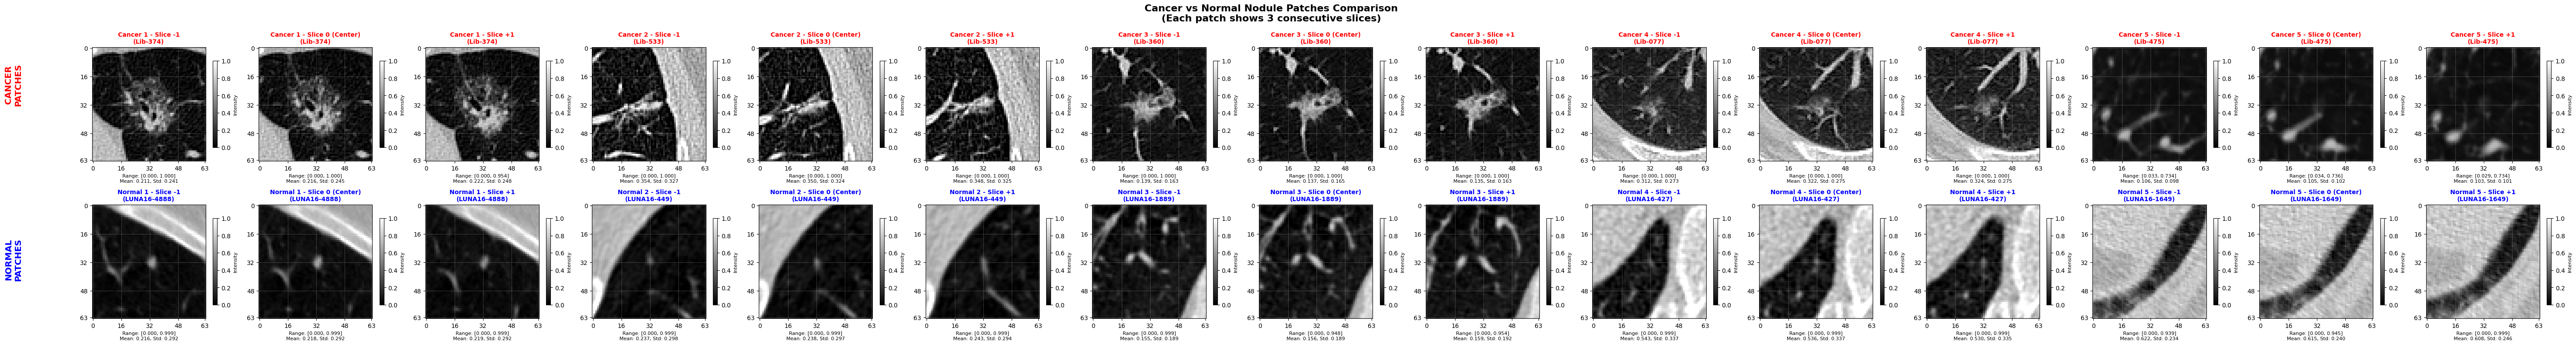


📊 Comparison Statistics:
   Cancer patches source: Real patient CT scans
   Normal patches source: High-quality LUNA16 dataset (Z>500 slices)
   Both datasets: Standardized to [0,1] range with lung windowing
   Patch format: (3, 64, 64) float32 - 3 consecutive axial slices
   ✅ Data formats are now highly compatible for training!

📈 Detailed Statistical Comparison (30 samples each)
  Mean Intensity:
    Cancer:  0.278948 ± 0.119897
    Normal:  0.351581 ± 0.104596
    Difference: 0.072633

  Standard Deviation:
    Cancer:  0.250828 ± 0.068785
    Normal:  0.299154 ± 0.041840
    Difference: 0.048327

  Minimum Value:
    Cancer:  0.000952 ± 0.005129
    Normal:  0.000000 ± 0.000000
    Difference: 0.000952

  Maximum Value:
    Cancer:  0.987405 ± 0.048710
    Normal:  0.999000 ± 0.000000
    Difference: 0.011595



In [8]:
# 🔍 随机展示癌症和正常结节patches对比 - 英文图注
import random
import matplotlib.pyplot as plt
import numpy as np
import os

def visualize_cancer_vs_normal_patches(cancer_dir: str, normal_dir: str, num_samples: int = 5):
    """
    随机展示癌症和正常结节patches的对比
    
    Args:
        cancer_dir: 癌症patches目录
        normal_dir: 正常结节patches目录 (标准化后)
        num_samples: 展示的样本数量
    """
    
    print(f"🔍 Randomly displaying {num_samples} cancer vs normal patches")
    print("="*60)
    
    # 1. 获取癌症patches文件列表
    cancer_files = []
    if os.path.exists(cancer_dir):
        for item in os.listdir(cancer_dir):
            item_path = os.path.join(cancer_dir, item)
            if os.path.isdir(item_path):
                npz_files = [f for f in os.listdir(item_path) if f.endswith('.npz')]
                if npz_files:
                    cancer_files.extend([os.path.join(item, f) for f in npz_files])
    
    # 2. 获取正常结节patches文件列表
    normal_files = []
    if os.path.exists(normal_dir):
        normal_files = [f for f in os.listdir(normal_dir) if f.endswith('.npz')]
    
    print(f"📁 Cancer patches found: {len(cancer_files)}")
    print(f"📁 Normal patches found: {len(normal_files)}")
    
    if len(cancer_files) == 0 or len(normal_files) == 0:
        print("❌ Not enough patches found for comparison")
        return
    
    # 3. 随机选择patches
    random.seed(42)
    selected_cancer = random.sample(cancer_files, min(num_samples, len(cancer_files)))
    selected_normal = random.sample(normal_files, min(num_samples, len(normal_files)))
    
    # 4. 创建可视化
    fig, axes = plt.subplots(2, num_samples * 3, figsize=(4*num_samples*3, 8))
    
    plt.suptitle('Cancer vs Normal Nodule Patches Comparison\n(Each patch shows 3 consecutive slices)', 
                 fontsize=16, fontweight='bold')
    
    # 5. 显示癌症patches (第一行)
    for i, cancer_file in enumerate(selected_cancer):
        try:
            # 加载癌症patch
            cancer_path = os.path.join(cancer_dir, cancer_file)
            cancer_data = np.load(cancer_path)
            cancer_patch = cancer_data['data']  # (3, 64, 64)
            cancer_data.close()
            
            # 获取文件信息
            lib_id = cancer_file.split('/')[0] if '/' in cancer_file else 'Unknown'
            
            # 显示3个切片
            for j in range(3):
                col_idx = i * 3 + j
                ax = axes[0, col_idx]
                
                im = ax.imshow(cancer_patch[j], cmap='gray', vmin=0, vmax=1)
                
                # 设置标题
                slice_names = ['Slice -1', 'Slice 0 (Center)', 'Slice +1']
                ax.set_title(f'Cancer {i+1} - {slice_names[j]}\n({lib_id})', 
                           fontsize=10, fontweight='bold', color='red')
                
                # 添加统计信息
                patch_slice = cancer_patch[j]
                ax.set_xlabel(f'Range: [{patch_slice.min():.3f}, {patch_slice.max():.3f}]\n'
                            f'Mean: {patch_slice.mean():.3f}, Std: {patch_slice.std():.3f}',
                            fontsize=8)
                
                # 设置网格和坐标轴
                ax.grid(True, alpha=0.3)
                ax.set_xticks([0, 16, 32, 48, 63])
                ax.set_yticks([0, 16, 32, 48, 63])
                
                # 添加颜色条
                cbar = plt.colorbar(im, ax=ax, shrink=0.6)
                cbar.set_label('Intensity', fontsize=8)
            
            print(f"✅ Cancer patch {i+1}: {lib_id}")
            
        except Exception as e:
            print(f"❌ Failed to load cancer patch {i+1}: {e}")
            continue
    
    # 6. 显示正常结节patches (第二行)
    for i, normal_file in enumerate(selected_normal):
        try:
            # 加载正常patch
            normal_path = os.path.join(normal_dir, normal_file)
            normal_data = np.load(normal_path)
            normal_patch = normal_data['data']  # (3, 64, 64)
            normal_data.close()
            
            # 获取文件信息
            file_id = normal_file.replace('patch_slice', '').replace('_det0.npz', '')
            
            # 显示3个切片
            for j in range(3):
                col_idx = i * 3 + j
                ax = axes[1, col_idx]
                
                im = ax.imshow(normal_patch[j], cmap='gray', vmin=0, vmax=1)
                
                # 设置标题
                slice_names = ['Slice -1', 'Slice 0 (Center)', 'Slice +1']
                ax.set_title(f'Normal {i+1} - {slice_names[j]}\n(LUNA16-{file_id})', 
                           fontsize=10, fontweight='bold', color='blue')
                
                # 添加统计信息
                patch_slice = normal_patch[j]
                ax.set_xlabel(f'Range: [{patch_slice.min():.3f}, {patch_slice.max():.3f}]\n'
                            f'Mean: {patch_slice.mean():.3f}, Std: {patch_slice.std():.3f}',
                            fontsize=8)
                
                # 设置网格和坐标轴
                ax.grid(True, alpha=0.3)
                ax.set_xticks([0, 16, 32, 48, 63])
                ax.set_yticks([0, 16, 32, 48, 63])
                
                # 添加颜色条
                cbar = plt.colorbar(im, ax=ax, shrink=0.6)
                cbar.set_label('Intensity', fontsize=8)
            
            print(f"✅ Normal patch {i+1}: {file_id}")
            
        except Exception as e:
            print(f"❌ Failed to load normal patch {i+1}: {e}")
            continue
    
    # 7. 添加行标签
    fig.text(0.02, 0.75, 'CANCER\nPATCHES', fontsize=14, fontweight='bold', 
             color='red', ha='center', va='center', rotation=90)
    fig.text(0.02, 0.25, 'NORMAL\nPATCHES', fontsize=14, fontweight='bold', 
             color='blue', ha='center', va='center', rotation=90)
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.05, top=0.90)
    plt.show()
    
    # 8. 打印对比统计
    print(f"\n📊 Comparison Statistics:")
    print(f"   Cancer patches source: Real patient CT scans")
    print(f"   Normal patches source: High-quality LUNA16 dataset (Z>500 slices)")
    print(f"   Both datasets: Standardized to [0,1] range with lung windowing")
    print(f"   Patch format: (3, 64, 64) float32 - 3 consecutive axial slices")
    print(f"   ✅ Data formats are now highly compatible for training!")

def compare_patch_statistics(cancer_dir: str, normal_dir: str, num_samples: int = 30):
    """比较癌症和正常patches的统计特征"""
    
    print(f"\n📈 Detailed Statistical Comparison ({num_samples} samples each)")
    print("="*60)
    
    # 收集统计数据的函数
    def collect_stats(file_list, base_dir, is_cancer=True):
        stats = {'means': [], 'stds': [], 'mins': [], 'maxs': [], 'shapes': [], 'dtypes': []}
        
        for file_path in file_list[:num_samples]:
            try:
                if is_cancer and '/' in file_path:
                    full_path = os.path.join(base_dir, file_path)
                else:
                    full_path = os.path.join(base_dir, file_path)
                
                data = np.load(full_path)
                patch = data['data']
                
                stats['means'].append(float(patch.mean()))
                stats['stds'].append(float(patch.std()))
                stats['mins'].append(float(patch.min()))
                stats['maxs'].append(float(patch.max()))
                stats['shapes'].append(patch.shape)
                stats['dtypes'].append(str(patch.dtype))
                
                data.close()
                
            except Exception as e:
                continue
        
        return stats
    
    # 获取文件列表
    cancer_files = []
    for item in os.listdir(cancer_dir):
        item_path = os.path.join(cancer_dir, item)
        if os.path.isdir(item_path):
            npz_files = [f for f in os.listdir(item_path) if f.endswith('.npz')]
            if npz_files:
                cancer_files.extend([os.path.join(item, f) for f in npz_files])
    
    normal_files = [f for f in os.listdir(normal_dir) if f.endswith('.npz')]
    
    # 随机选择
    random.seed(42)
    selected_cancer = random.sample(cancer_files, min(num_samples, len(cancer_files)))
    selected_normal = random.sample(normal_files, min(num_samples, len(normal_files)))
    
    # 收集统计
    cancer_stats = collect_stats(selected_cancer, cancer_dir, is_cancer=True)
    normal_stats = collect_stats(selected_normal, normal_dir, is_cancer=False)
    
    # 打印对比
    metrics = ['means', 'stds', 'mins', 'maxs']
    labels = ['Mean Intensity', 'Standard Deviation', 'Minimum Value', 'Maximum Value']
    
    for metric, label in zip(metrics, labels):
        if cancer_stats[metric] and normal_stats[metric]:
            cancer_val = np.mean(cancer_stats[metric])
            normal_val = np.mean(normal_stats[metric])
            cancer_std = np.std(cancer_stats[metric])
            normal_std = np.std(normal_stats[metric])
            
            print(f"  {label}:")
            print(f"    Cancer:  {cancer_val:.6f} ± {cancer_std:.6f}")
            print(f"    Normal:  {normal_val:.6f} ± {normal_std:.6f}")
            print(f"    Difference: {abs(cancer_val - normal_val):.6f}")
            print()

# 执行可视化对比
cancer_patch_dir = "/home/maweicheng/database/Patch"
normal_patch_dir = "/home/maweicheng/database/LUNA/nocancer_patches_standardized"

print("🎨 Starting Cancer vs Normal Patches Visualization...")
visualize_cancer_vs_normal_patches(cancer_patch_dir, normal_patch_dir, num_samples=5)

# 执行统计对比
compare_patch_statistics(cancer_patch_dir, normal_patch_dir, num_samples=30)